# Modelling & Model Assessments

In [5]:
# Importing Libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Plot Customisation
%matplotlib inline
sns.set_theme(style = "whitegrid", palette = "pastel")

In [1]:
# Defining file variables
file_path = '../data/analysis_data/eda_customer_churn.pkl'
result_path = '../results/'
result_name = 'model_comparison_result'
result_ext = '.csv'
results = {}

# Modelling Parameters
testing_size = 0.2

# Target column
target = 'Churn'

In [2]:
# Separating & Categorising Features
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

service_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'TechSupport']

payment_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']

categorical_features = list(set(service_features + payment_features) - set(binary_features))

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [3]:
def load_preprocess(filename, drop_aux, one_hot, encode_binary, encode_gender) -> pd.DataFrame:
    churn_df = pd.read_pickle('../data/analysis_data/eda_customer_churn.pkl')
    if drop_aux:
        # Dropping customerID
        churn_df = churn_df.drop(columns = ['customerID'])
    
    if one_hot:
        ohe = OneHotEncoder(categories = 'auto', sparse_output = False, handle_unknown = 'ignore')
        
        # Transforming & Fitting Categorical Columns
        categorical_features_encoded = ohe.fit_transform(churn_df[categorical_features])

        # Making the transformed data into a DataFrame
        column_names = ohe.get_feature_names_out(categorical_features)
        categorical_features_encoded = pd.DataFrame(data = categorical_features_encoded, columns = column_names, index = churn_df.index)

        # Dropping Categorical Features from Orignial DataFrame
        churn_df = churn_df.drop(columns = categorical_features)

        # Concatenating Encoded Columns
        churn_df = pd.concat([churn_df, categorical_features_encoded], axis = 1)

    if encode_binary:
        # Features for Mapping
        mapping_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

        # Mapping of `Yes` and `No` to `1` and `0`
        for col in mapping_features:
            churn_df[col] = churn_df[col].map({'Yes': 1, 'No': 0})
    
    if encode_gender:
        # Mapping 'Male'/'Female' to 1/0
        churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})

    return churn_df



In [4]:
# Loading in the Data
df = load_preprocess(filename = file_path, drop_aux = True, one_hot = True, encode_binary = True, encode_gender = True)

# Preview of Data
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Handling Class Imbalance with SMOTE
In our dataset, the target variable `Churn` is imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favour the majority class (non-churn) which will cause a failure in to correctly classify minority class instances. Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business action.

To resolve this, I used **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. SMOTE workds by creating *synthetic examples* of the minority class based on the feature space similarities between existing minority samples. 

I applied SMOTE to the **training dataset** only to avoid data leakage. 

In [5]:
# Defining the X and y
y = df[target]
X = df.drop(columns = target, axis = 1)

# Performing the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testing_size, random_state = 42)

## Logistic Regression

In [6]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a logistic regression model
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),       # Scale it down – mean=0, std=1, no funny business
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
    ])

# Define the grid of hyperparameters to try for the logistic regression model
lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'clf__penalty': ['l1', 'l2'],               # Penalty type
    'clf__max_iter': [100, 200, 300, 500, 1000]
}

# Set up a grid search with cross-validation to find the best combo of parameters
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

# Train the model and let the grid search work its magic
lr_grid_search.fit(X_train, y_train)

# Print the best set of parameters found – the winning combo
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


In [7]:
# Make predictions on the test set
lr_y_pred = lr_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
lr_y_proba = lr_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)

# Calculate ROC AUC score – area under the curve
lr_roc_auc = roc_auc_score(y_test, lr_y_proba)

# Store all the important performance metrics and artifacts in a dictionary for later use or plotting
results["Logistic Regression"] = {
    "values": {
        "accuracy": accuracy_score(y_test, lr_y_pred),
        "precision": precision_score(y_test, lr_y_pred),
        "recall": recall_score(y_test, lr_y_pred),
        "f1": f1_score(y_test, lr_y_pred),
        "roc_auc": roc_auc_score(y_test, lr_y_proba),
    },
    "roc_curve": {
        "fpr": lr_fpr,
        "tpr": lr_tpr,
        "roc_auc": lr_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, lr_y_pred),
    "model": lr_grid_search.best_estimator_,
    "params": lr_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1033
           1       0.50      0.75      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.75      1407



## Support Vector Machine (SVM) Classifier

In [8]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a support vector classifier
svm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state = 42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state = 42))
])

svm_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

svm_grid_search.fit(X_train, y_train)
print("Best parameters:", svm_grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


In [9]:
# Make predictions on the test set
svm_y_pred = svm_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
svm_y_proba = svm_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)

# Calculate ROC AUC score – area under the curve
svm_roc_auc = roc_auc_score(y_test, svm_y_proba)

# Store all the important performance metrics and artifacts in a dictionary for later use or plotting
results["SVM"] = {
    "values": {
        "accuracy": accuracy_score(y_test, svm_y_pred),
        "precision": precision_score(y_test, svm_y_pred),
        "recall": recall_score(y_test, svm_y_pred),
        "f1": f1_score(y_test, svm_y_pred),
        "roc_auc": roc_auc_score(y_test, svm_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": svm_fpr,
        "tpr": svm_tpr,
        "roc_auc": svm_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, svm_y_pred),
    "model": svm_grid_search.best_estimator_,
    "params": svm_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.69      0.59       374

    accuracy                           0.75      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.75      0.76      1407



## Random Forest Classifier

In [10]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a logistic regression model
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state = 42)),
    ('clf', RandomForestClassifier(random_state = 42))
])

# Define the grid of hyperparameters to try for the logistic regression model
rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Set up a grid search with cross-validation to find the best combo of parameters
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv = 5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train the model and let the grid search work its magic
rf_grid_search.fit(X_train, y_train)

# Print the best set of parameters found – the winning combo
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


In [11]:
# Make predictions on the test set
rf_y_pred = rf_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
rf_y_proba = rf_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_proba)

# Calculate ROC AUC score – area under the curve
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)

# Store all the important performance metrics and artifacts in a dictionary for later use or plotting
results["Random Forest"] = {
    "values": {
        "accuracy": accuracy_score(y_test, rf_y_pred),
        "precision": precision_score(y_test, rf_y_pred),
        "recall": recall_score(y_test, rf_y_pred),
        "f1": f1_score(y_test, rf_y_pred),
        "roc_auc": roc_auc_score(y_test, rf_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": rf_fpr,
        "tpr": rf_tpr,
        "roc_auc": rf_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, rf_y_pred),
    "model": rf_grid_search.best_estimator_,
    "params": rf_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.69      0.59       374

    accuracy                           0.75      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.75      0.76      1407



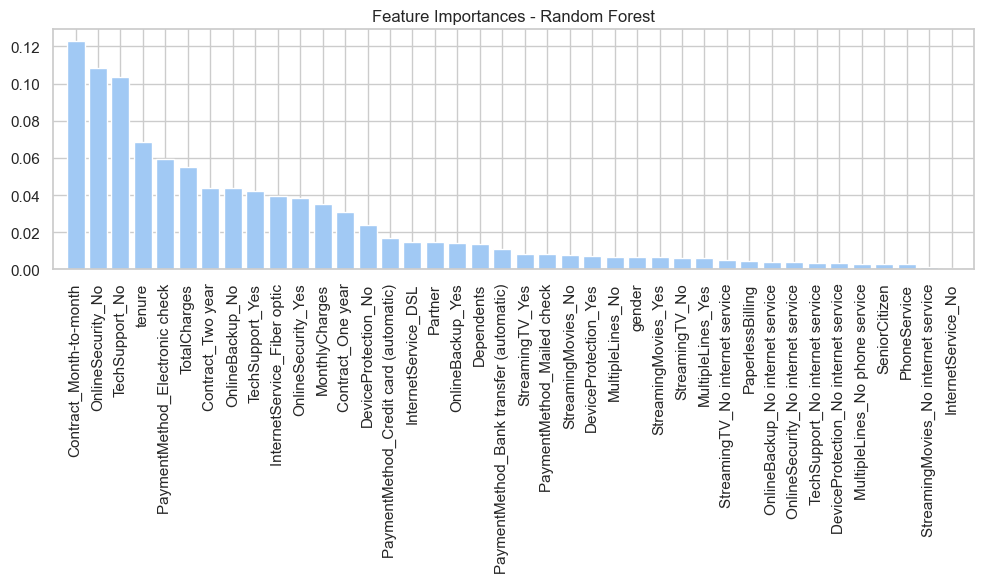

In [12]:
# Feature importance for Random Forest
importances = rf_grid_search.best_estimator_.named_steps['clf'].feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]

# Creating the Figure
plt.figure(figsize=(10, 6))
# Creating the Plot
plt.bar(range(X.shape[1]), importances[indices], align='center')

# Customising the Plot
plt.title("Feature Importances - Random Forest")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

## Model Comparison

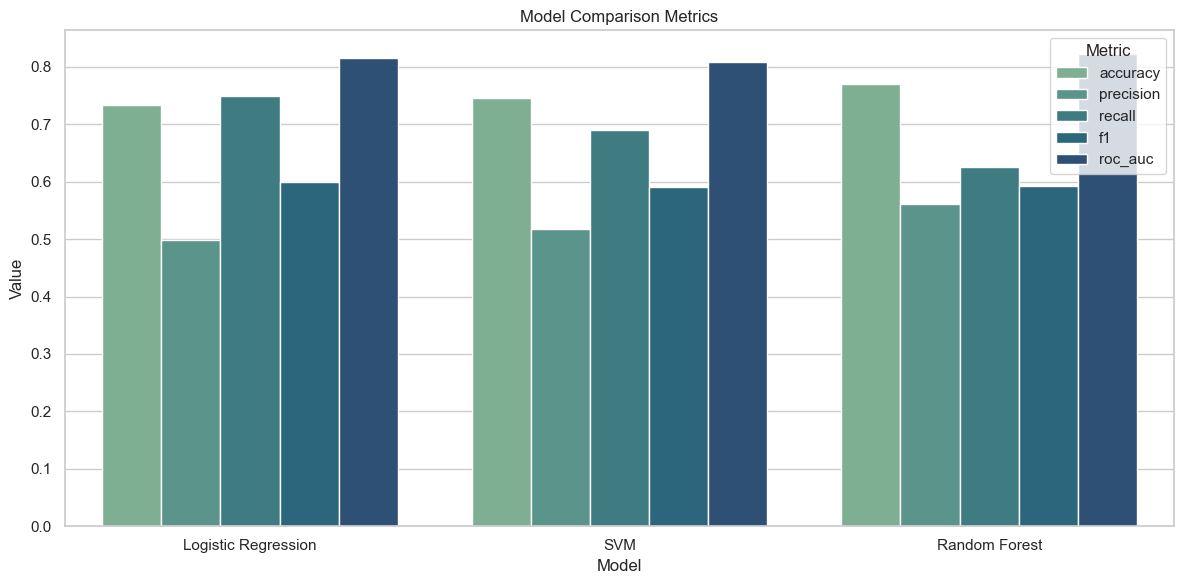

In [13]:
# Model Metric Comparison
dynamic_df = pd.DataFrame.from_dict(
    {k: v["values"] for k, v in results.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Model'})

dynamic_df = dynamic_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Creating the Figure
plt.figure(figsize=(12, 6))

# Create the Plot
sns.barplot(data=dynamic_df, x='Model', y='Value', hue='Metric', palette = 'crest')

# Customising the Plot
plt.title('Model Comparison Metrics')
plt.tight_layout()

# Showing the Plot
plt.show()

In [14]:
# Saving off the results
results_df = pd.DataFrame.from_dict(
    {model: res["values"] for model, res in results.items()},
    orient='index'
)

results_df.to_csv(f"{result_path}{result_name}{datetime.now().strftime('%Y%m%d_%H%M%S')}.{result_ext}")
results_df

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.733475,0.499109,0.748663,0.598930,0.814439
SVM,0.746269,0.517034,0.689840,0.591065,0.808941
Random Forest,0.770434,0.561151,0.625668,0.591656,0.822227


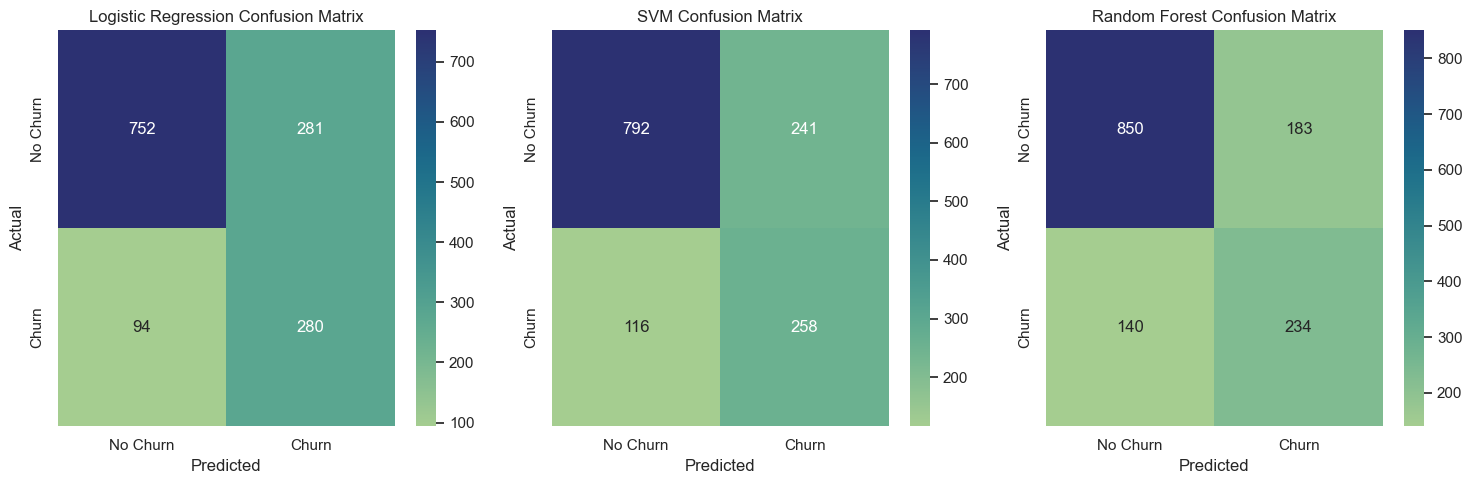

In [15]:
# Plotting Confusion Matrices
n_models = len(results)
cols = 3
rows = (n_models + cols - 1) // cols

# Creating the Figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]

# Creating the Plot
for i, (model_name, res) in enumerate(results.items()):
    cm = res["confusion_matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=axes[i])

    # Customising the Plot
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["No Churn", "Churn"])
    axes[i].set_yticklabels(["No Churn", "Churn"])
plt.tight_layout()

# Showing the Plot
plt.show();

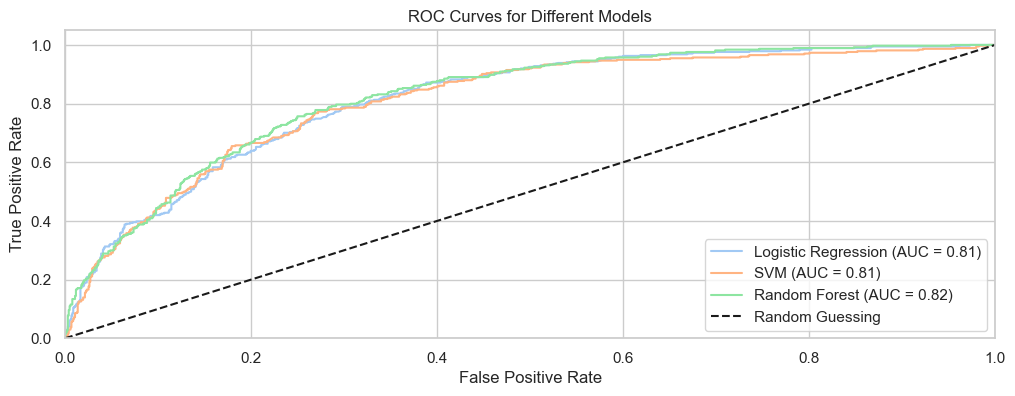

In [16]:
# Plotting the ROC Curves

# Creating the Figure
plt.figure(figsize=(12, 4))

for model_name, res in results.items():
    fpr = res["roc_curve"]["fpr"]
    tpr = res["roc_curve"]["tpr"]
    auc_score = res["roc_curve"]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Customising the Plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Different Models')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)

# Showing the Plot
plt.show()